# Zoning & Land Use Applications

In this notebook I look at trends in Zoning & Land Use applications in NYC over time. I pulled the data from the NYC Planning Labs website:

https://zap.planning.nyc.gov/projects?boroughs=Brooklyn&dcp_publicstatus=Completed%2CFiled%2CIn%20Public%20Review%2CUnknown

The csv file read from in the following cells contains all ZAP applications regardless of borough, year, or project stage. Subsets of this data are made for Brooklyn and Red Hook.

To get a sense of ZAP applications over time, I need to find other ways to get filing information since the data download provided on the NYC Planning Labs website doesn't include the initial filing date but only the "lastmilestonedate," which may be less informative.

## Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from fiona.crs import from_epsg
import matplotlib.pylab as plt
from matplotlib import cm
import requests

### ZAP for all of NYC

In [2]:
zap = pd.read_csv('data/primary_source_data/zap.csv')
zap.head()

,dcp_name,dcp_ceqrnumber,dcp_projectname,dcp_projectbrief,dcp_publicstatus_simp,dcp_borough,dcp_ulurp_nonulurp,dcp_communitydistricts,actiontypes,dcp_certifiedreferred,dcp_femafloodzonea,dcp_femafloodzonecoastala,dcp_femafloodzoneshadedx,dcp_femafloodzonev,applicants,lastmilestonedate,total_projects,has_centroid,center,ulurpnumbers
0,2019R0029,19DCP168R,347 Flagg Place,This is a private application submitted by Joh...,Filed,Staten Island,ULURP,SI02,ZA,NaN,False,False,False,False,John Elefterakis,2019-06-24T04:00:00.000Z,29013,True,"[-74.109445117468,40.5839376852462]","[""190351ZAR""]"
1,P2017R0360,19DCP150R,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA;ZA,2019-04-03T04:00:00.000Z,False,False,False,False,Peter Calvanico;Peter Calvanico,2019-06-10T04:00:00.000Z,29013,False,"[null,null]","[""N190308ZAR"",""N190310ZAR""]"
2,2019M0149,19DCP110Y,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,2019-01-28T19:22:12.000Z,False,False,False,False,DCP,2019-06-03T04:00:00.000Z,29013,False,"[null,null]","[""N190230ZRY""]"
3,2019Y0061,18DOC001Y,New York City Borough - Based Jail System,DOC is proposing to implement a borough-based ...,In Public Review,Citywide,ULURP,MN01;BK02;QN09;BX01,PS;ZM;ZS;ZS;ZS;PS;ZS;MM;ZS;ZS;ZS;ZS;ZS;ZS;ZS;H...,2019-03-25T19:06:01.000Z,False,False,False,False,DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DO...,2019-06-03T04:00:00.000Z,29013,True,"[-73.9010519868197,40.7447616970607]","[""190104MMM"",""190116MMK"",""190117MMQ"",""190252MM..."
4,P2018Q0042,19DCP003Q,47-15 34th Avenue Rezoning,This is a private application by Ashley Young ...,In Public Review,Queens,ULURP,QN01,ZM;ZR;ZR;ZR;ZR;ZM;ZM;ZM;ZR;ZR;ZR;ZR;ZR;ZR;ZR;Z...,2018-11-13T20:13:08.000Z,False,False,False,False,John Young Associates LLC;Ashley Young LLC;Ash...,2019-06-03T04:00:00.000Z,29013,True,"[-73.9148996827753,40.7542546716476]","[""C180530ZMQ"",""N180529ZRQ""]"


In [3]:
zap.shape

(29013, 20)

In [4]:
# Get counts per location
zap_bor_gps = zap.groupby(['dcp_borough']).count()
zap_bor_gps.reset_index(inplace=True)
zap_bor_gps = zap_bor_gps[['dcp_borough', 'dcp_name']]
zap_bor_gps.rename(columns={'dcp_name':'count'}, inplace=True)
zap_bor_gps

,dcp_borough,count
0,Bronx,2855
1,Brooklyn,4175
2,Citywide,372
3,Manhattan,10800
4,Queens,3039
5,Staten Island,7772


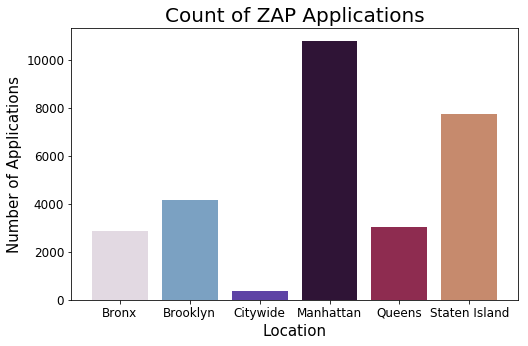

In [5]:
# Raw count
x = zap_bor_gps['dcp_borough']
y = zap_bor_gps['count']

plt.figure(figsize=(8,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("Count of ZAP Applications", fontsize=20)
plt.xlabel("Location", fontsize=15)
plt.ylabel("Number of Applications", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Dealing with latitude and longitude

In [6]:
print("Number of projects in NYC missing latitude-longitude information for the project center: {}".format\
      (zap['center'].str.contains('null').sum()))

Number of projects in NYC missing latitude-longitude information for the project center: 8415


In [7]:
# Create a dataframe where all rows have lon lat info
zap_ll = zap[zap['center'].str.contains('null')==False]
zap_ll.head()

,dcp_name,dcp_ceqrnumber,dcp_projectname,dcp_projectbrief,dcp_publicstatus_simp,dcp_borough,dcp_ulurp_nonulurp,dcp_communitydistricts,actiontypes,dcp_certifiedreferred,dcp_femafloodzonea,dcp_femafloodzonecoastala,dcp_femafloodzoneshadedx,dcp_femafloodzonev,applicants,lastmilestonedate,total_projects,has_centroid,center,ulurpnumbers
0,2019R0029,19DCP168R,347 Flagg Place,This is a private application submitted by Joh...,Filed,Staten Island,ULURP,SI02,ZA,NaN,False,False,False,False,John Elefterakis,2019-06-24T04:00:00.000Z,29013,True,"[-74.109445117468,40.5839376852462]","[""190351ZAR""]"
3,2019Y0061,18DOC001Y,New York City Borough - Based Jail System,DOC is proposing to implement a borough-based ...,In Public Review,Citywide,ULURP,MN01;BK02;QN09;BX01,PS;ZM;ZS;ZS;ZS;PS;ZS;MM;ZS;ZS;ZS;ZS;ZS;ZS;ZS;H...,2019-03-25T19:06:01.000Z,False,False,False,False,DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DOC;DO...,2019-06-03T04:00:00.000Z,29013,True,"[-73.9010519868197,40.7447616970607]","[""190104MMM"",""190116MMK"",""190117MMQ"",""190252MM..."
4,P2018Q0042,19DCP003Q,47-15 34th Avenue Rezoning,This is a private application by Ashley Young ...,In Public Review,Queens,ULURP,QN01,ZM;ZR;ZR;ZR;ZR;ZM;ZM;ZM;ZR;ZR;ZR;ZR;ZR;ZR;ZR;Z...,2018-11-13T20:13:08.000Z,False,False,False,False,John Young Associates LLC;Ashley Young LLC;Ash...,2019-06-03T04:00:00.000Z,29013,True,"[-73.9148996827753,40.7542546716476]","[""C180530ZMQ"",""N180529ZRQ""]"
5,P2015K0351,16DCP134K,1010 Pacific Street Rezoning,This is a private application by 1010 Pacific ...,In Public Review,Brooklyn,ULURP,BK08,ZM;ZR;ZR;ZR;ZM;ZR;ZM;ZR;ZR;ZR;ZR;ZM;ZR;ZM;ZM;Z...,2018-10-29T18:13:03.000Z,False,False,False,False,1010 Pacific Street LLC;1010 Pacific Street LL...,2019-05-28T04:00:00.000Z,29013,True,"[-73.959537931908,40.6789975203786]","[""C180042ZMK"",""N180043ZRK""]"
6,P2013K0549,17DCP205K,1050 Pacific Street Rezoning,This is a private application by 1050 Pacific ...,In Public Review,Brooklyn,ULURP,BK08,ZM;ZM;ZM;ZR;ZR;ZR;ZR;ZR;ZR;ZM;ZR;ZM;ZR;ZR;ZR;Z...,2018-10-29T18:23:57.000Z,False,False,False,False,Mark Rigerman;Mark Rigerman;Mark Rigerman;Mark...,2019-05-28T04:00:00.000Z,29013,True,"[-73.9580891085031,40.6785645542978]","[""C160175ZMK"",""N160176ZRK""]"


### ZAP for Brooklyn only

In [8]:
zap_bk = zap_ll[zap_ll['dcp_borough']=='Brooklyn']
zap_bk.head()

,dcp_name,dcp_ceqrnumber,dcp_projectname,dcp_projectbrief,dcp_publicstatus_simp,dcp_borough,dcp_ulurp_nonulurp,dcp_communitydistricts,actiontypes,dcp_certifiedreferred,dcp_femafloodzonea,dcp_femafloodzonecoastala,dcp_femafloodzoneshadedx,dcp_femafloodzonev,applicants,lastmilestonedate,total_projects,has_centroid,center,ulurpnumbers
5,P2015K0351,16DCP134K,1010 Pacific Street Rezoning,This is a private application by 1010 Pacific ...,In Public Review,Brooklyn,ULURP,BK08,ZM;ZR;ZR;ZR;ZM;ZR;ZM;ZR;ZR;ZR;ZR;ZM;ZR;ZM;ZM;Z...,2018-10-29T18:13:03.000Z,False,False,False,False,1010 Pacific Street LLC;1010 Pacific Street LL...,2019-05-28T04:00:00.000Z,29013,True,"[-73.959537931908,40.6789975203786]","[""C180042ZMK"",""N180043ZRK""]"
6,P2013K0549,17DCP205K,1050 Pacific Street Rezoning,This is a private application by 1050 Pacific ...,In Public Review,Brooklyn,ULURP,BK08,ZM;ZM;ZM;ZR;ZR;ZR;ZR;ZR;ZR;ZM;ZR;ZM;ZR;ZR;ZR;Z...,2018-10-29T18:23:57.000Z,False,False,False,False,Mark Rigerman;Mark Rigerman;Mark Rigerman;Mark...,2019-05-28T04:00:00.000Z,29013,True,"[-73.9580891085031,40.6785645542978]","[""C160175ZMK"",""N160176ZRK""]"
8,P2017K0429,18HPD104K,1921 Atlantic Ave - MWBE Site B,This is an application by HPD requesting a UDA...,In Public Review,Brooklyn,ULURP,BK03,ZM;ZR;HA;ZM;HA;ZM;ZR;HU;HU;HU;HU;HU;ZM;HU;HU;H...,2018-11-13T20:33:07.000Z,False,False,False,False,HPD;HPD;HPD;HPD;HPD;HPD;HPD;HPD;HPD;HPD;HPD;HP...,2019-05-20T04:00:00.000Z,29013,True,"[-73.920328878287,40.677345947327]","[""190160HAK"",""190161ZMK"",""190163HUK"",""N190162Z..."
9,P2013K0364,18DCP104K,273 Avenue U Rezoning,This is a private application by Ciarafour Rea...,In Public Review,Brooklyn,ULURP,BK11,ZM;ZM;ZR;ZR;ZR;ZR;ZR;ZR;ZR;ZM;ZR;ZR;ZR;ZM;ZM;Z...,2019-02-11T18:40:09.000Z,False,False,False,False,"CIARAFOUR REALTY, LLC;CIARAFOUR REALTY, LLC;CI...",2019-05-20T04:00:00.000Z,29013,True,"[-73.9736549702216,40.5972231305137]","[""C180164ZMK"",""N180165ZRK""]"
10,P2016K0318,18DCP180K,3513 Atlantic Avenue Rezoning,This is a private application by Leemilt's Pet...,In Public Review,Brooklyn,ULURP,BK05,ZM;ZM;ZM,2019-03-11T17:15:53.000Z,False,False,False,False,Leemilt's Petroleum;Leemilt's Petroleum;Leemil...,2019-05-19T04:00:00.000Z,29013,True,"[-73.8676552720272,40.6831443832046]","[""190222ZMK""]"


In [9]:
print("Number of Brooklyn ZAP applications (with lon lat info): {}".format(zap_bk.shape[0]))

Number of Brooklyn ZAP applications (with lon lat info): 2669


### ZAP for Red Hook only

In [10]:
# Pull in the shapefile of the combined census tracts for Red Hook for spatial join
files = !ls data/created_data/rh_comb_tract
print(list(enumerate(files)))

[(0, 'rh_comb_tract.cpg'), (1, 'rh_comb_tract.dbf'), (2, 'rh_comb_tract.prj'), (3, 'rh_comb_tract.shp'), (4, 'rh_comb_tract.shx')]


In [11]:
# Census tracts for Red Hook
shp = files[3]
loc = 'data/created_data/rh_comb_tract/' + shp
rh_tracts = gpd.GeoDataFrame.from_file(loc)
rh_tracts.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,geometry
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,POLYGON ((-74.00485241669628 40.68566813081066...


In [12]:
# Cast the center column as a string for the following split
zap_ll['center'] = zap_ll['center'].astype(str)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
# Create longitude and latitude columns
zap_ll['lon'], zap_ll['lat'] = zap_ll['center'].str.split(',', 1).str
zap_ll.drop(['center'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [14]:
# Cleanup
zap_ll['lon'] = zap_ll['lon'].map(lambda x: x.lstrip('['))
zap_ll['lat'] = zap_ll['lat'].map(lambda x: x.rstrip(']'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Now cast them as floats for the following step
zap_ll['lon'] = zap_ll['lon'].astype(float)
zap_ll['lat'] = zap_ll['lat'].astype(float)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Create geometry
zap_ll['lonlat'] = list(zip(zap_ll['lon'], zap_ll['lat']))
zap_ll['geometry'] = zap_ll[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
zap_ll = gpd.GeoDataFrame(zap_ll)
zap_ll.crs = from_epsg(4326)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Now a spatial join to only keep the ZAP data for Red Hook
rh_only = gpd.tools.sjoin(rh_tracts,zap_ll)

/anaconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [18]:
rh_only.drop(['geometry'], axis=1, inplace=True)

In [19]:
rh_only['geometry'] = rh_only[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

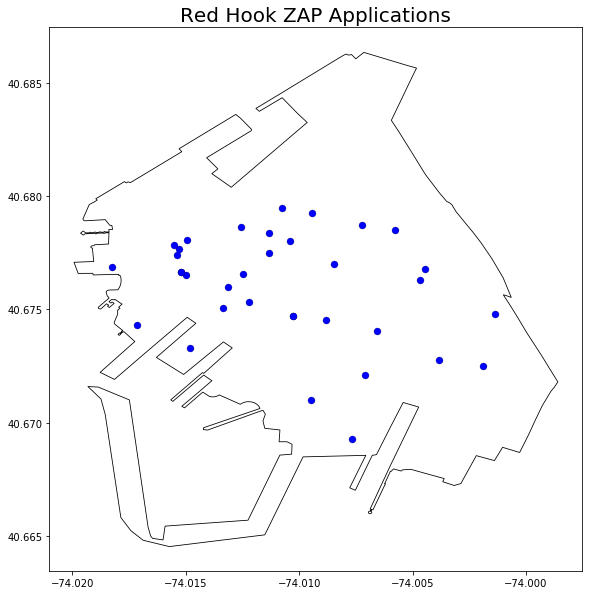

In [20]:
f, ax = plt.subplots(figsize=(15,10))
rh_tracts.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
rh_only.plot(alpha=1, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=50)
plt.title("Red Hook ZAP Applications", fontsize=20)
plt.show()

# Google geocode

Because the ZAP application data pulled from the NYC Planning Labs website was missing latitude and longitude information for 8,415 applications, I used Google's geocoding API feature to try and fill in that missing information.

Big thanks to data scientist Shane Lynn for publishing his script that will execute batch geocoding queries. His script can be found at the following URL:

https://www.shanelynn.ie/batch-geocoding-in-python-with-google-geocoding-api/#script-code

Note that in order for the query and the next couple cells to run, you will need your own Google Maps geocoding API key saved in a text file called "google_api.txt." Do not include any other information in that file.

In [21]:
# Get a dataframe of ZAP applications missing the latitude and longitude for the project center
zap_null = zap[zap['center'].str.contains('null')==True]

In [22]:
zap_null.head()

,dcp_name,dcp_ceqrnumber,dcp_projectname,dcp_projectbrief,dcp_publicstatus_simp,dcp_borough,dcp_ulurp_nonulurp,dcp_communitydistricts,actiontypes,dcp_certifiedreferred,dcp_femafloodzonea,dcp_femafloodzonecoastala,dcp_femafloodzoneshadedx,dcp_femafloodzonev,applicants,lastmilestonedate,total_projects,has_centroid,center,ulurpnumbers
1,P2017R0360,19DCP150R,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA;ZA,2019-04-03T04:00:00.000Z,False,False,False,False,Peter Calvanico;Peter Calvanico,2019-06-10T04:00:00.000Z,29013,False,"[null,null]","[""N190308ZAR"",""N190310ZAR""]"
2,2019M0149,19DCP110Y,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,2019-01-28T19:22:12.000Z,False,False,False,False,DCP,2019-06-03T04:00:00.000Z,29013,False,"[null,null]","[""N190230ZRY""]"
17,2019R0264,19DCP130R,SS 217 Main Street,This is a private application by Philese Black...,Completed,Staten Island,Non-ULURP,SI03,RC,2019-04-26T17:50:39.000Z,False,False,False,False,Philese Blackler,2019-04-25T04:00:00.000Z,29013,False,"[null,null]","[""N190269RCR""]"
18,P2018M0038,03DCP031M,66 Hudson Boulevard Streetscape Text Amendment,A private application for a text amendment to ...,In Public Review,Manhattan,Non-ULURP,MN04,ZR,2018-12-17T05:00:00.000Z,False,False,False,False,Tishman Speyer,2019-04-24T21:53:10.000Z,29013,False,"[null,null]","[""N190205ZRM""]"
38,2019K0287,NaN,Consolidation of ACS Division of Child Protection,This is a notice of intent by the New York Cit...,Completed,Brooklyn,Non-ULURP,BK02,PX;PX,2019-03-20T18:05:22.000Z,False,False,False,False,ACS;DCAS,2019-04-22T04:00:00.000Z,29013,False,"[null,null]","[""N190254PXK""]"


In [23]:
# Form a list of addresses for geocoding:
addresses = (zap_null['dcp_projectname'] + ', ' + zap_null['dcp_borough'] + ', NY, US').tolist()

In [24]:
# To retrieve API key for following query
API_KEY = open('google_api.txt', 'r').readlines()[0][:] # api stored in seperate .txt file

In [25]:
# Function
def get_google_results(address, api_key=None, return_full_response=False):
    # Set up Geocoding url
    geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}".format(address)
    if api_key is not None:
        geocode_url = geocode_url + "&key={}".format(api_key)
        
    # Ping google for the reuslts:
    results = requests.get(geocode_url)
    # Results will be in JSON format - convert to dict using requests functionality
    results = results.json()
    
    # if there's no results or an error, return empty results.
    if len(results['results']) == 0:
        output = {
            "formatted_address" : None,
            "latitude": None,
            "longitude": None,
            "accuracy": None,
            "google_place_id": None,
            "type": None,
            "postcode": None
        }
    else:    
        answer = results['results'][0]
        output = {
            "formatted_address" : answer.get('formatted_address'),
            "latitude": answer.get('geometry').get('location').get('lat'),
            "longitude": answer.get('geometry').get('location').get('lng'),
            "accuracy": answer.get('geometry').get('location_type'),
            "google_place_id": answer.get("place_id"),
            "type": ",".join(answer.get('types')),
            "postcode": ",".join([x['long_name'] for x in answer.get('address_components') 
                                  if 'postal_code' in x.get('types')])
        }
        
    # Append some other details:    
    output['input_string'] = address
    output['number_of_results'] = len(results['results'])
    output['status'] = results.get('status')
    if return_full_response is True:
        output['response'] = results
    
    return output

### API request for all missing address info

In [26]:
# Function for api call
def google_geo_api(chunk):
    # Create a list to hold results
    results = []
    # Go through each address in turn
    for address in chunk:
        geocode_result = get_google_results(address, API_KEY)
        results.append(geocode_result)           
    return results

In [27]:
# Only uncomment if you want to rerun and request 8k+ API calls
# all_results = google_geo_api(addresses)

In [28]:
# All results have already been pulled from Google and saved as csv
google_results = pd.read_csv('data/zap_google_geocode/all_zap_geocoded.csv')
google_results.head()

,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type
0,ROOFTOP,"45 Douglas Ct, Staten Island, NY 10304, USA",ChIJ8_sf4PZOwokRkHmQtiRNrvk,"45 Douglas Court, Staten Island, NY, US",40.608527,-74.091696,1,10304,OK,street_address
1,APPROXIMATE,"Manhattan, New York, NY, USA",ChIJYeZuBI9YwokRjMDs_IEyCwo,Residential Tower Mechanical Voids Text Amendm...,40.783060,-73.971249,1,NaN,OK,"political,sublocality,sublocality_level_1"
2,ROOFTOP,"217 Main St, Staten Island, NY 10307, USA",ChIJe41FVZnKw4kRNZEBZ286_zg,"SS 217 Main Street, Staten Island, NY, US",40.509931,-74.247232,1,10307,OK,premise
3,ROOFTOP,"66 Hudson Blvd E, West, NY 10001, USA",ChIJSbI7fbNZwokRhr1NS-eDyHc,66 Hudson Boulevard Streetscape Text Amendment...,40.755680,-74.000510,1,10001,OK,street_address
4,APPROXIMATE,"Brooklyn, NY, USA",ChIJCSF8lBZEwokRhngABHRcdoI,Consolidation of ACS Division of Child Protect...,40.678178,-73.944158,1,NaN,OK,"political,sublocality,sublocality_level_1"


In [29]:
# Number of results returned
google_results.shape

(8415, 10)

In [30]:
# Turn that df into a gdf
google_results['lonlat'] = list(zip(google_results.longitude, google_results.latitude))
google_results['geometry'] = google_results[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
google_results = gpd.GeoDataFrame(google_results)
google_results.crs = from_epsg(4326)

In [31]:
# Join the Google results with the Red Hook census tracts to see which ones fall within Red Hook
google_rh = gpd.tools.sjoin(rh_tracts,google_results)
google_rh.head()

/anaconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng,...,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type,lonlat
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"700 Columbia St, Brooklyn, NY 11231, USA",ChIJmWYrzpZawokRcLQJiIrmZxs,"POLICE AUTO POUND, Queens, NY, US",40.665264,-74.014326,1,11231,OK,"establishment,point_of_interest,police","(-74.0143265, 40.6652641)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"5 Sigourney St 2nd floor, Brooklyn, NY 11231, USA",ChIJgXgKRYxawokRYcQddJBiLps,"MURRELL BUS, Citywide, NY, US",40.673361,-74.010304,2,11231,OK,"establishment,point_of_interest,travel_agency","(-74.01030379999997, 40.6733615)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"Red Hook, Brooklyn, NY, USA",ChIJv4cTh4tawokRQFmjdeb5YyI,"RED HOOK POLLUTION CONTROL PLANT, Brooklyn, NY...",40.673368,-74.008319,1,NaN,OK,"neighborhood,political","(-74.00831889999998, 40.67336760000001)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"Red Hook, Brooklyn, NY, USA",ChIJv4cTh4tawokRQFmjdeb5YyI,"RED HOOK PENINSULA 3RD AMEND URP, Brooklyn, NY...",40.673368,-74.008319,1,NaN,OK,"neighborhood,political","(-74.00831889999998, 40.67336760000001)"
0,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705,...,"Red Hook, Brooklyn, NY, USA",ChIJv4cTh4tawokRQFmjdeb5YyI,"RED HOOK WATER POLLUTION, Brooklyn, NY, US",40.673368,-74.008319,1,NaN,OK,"neighborhood,political","(-74.00831889999998, 40.67336760000001)"


In [32]:
# Fix the geometry column
google_rh.drop(['geometry'], axis=1, inplace=True)

In [33]:
# Create a new geometry column
google_rh['geometry'] = google_rh[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
google_rh.reset_index(drop=True, inplace=True)

## Dropping some Google results

I dropped some of the results from the Google API call since they don't appear to be related to Red Hook based on the project names. I won't be able to do this for the other results for other boroughs since there are too many rows to review. But there are probably many false positives so I'm not going to merge those results from Google back with the original data.

In [34]:
google_rh.input_string.values

array(['POLICE AUTO POUND, Queens, NY, US',
       'MURRELL BUS, Citywide, NY, US',
       'RED HOOK POLLUTION CONTROL PLANT, Brooklyn, NY, US',
       'RED HOOK PENINSULA 3RD AMEND URP, Brooklyn, NY, US',
       'RED HOOK WATER POLLUTION, Brooklyn, NY, US',
       '2ND AMENDMENT TO RED HOOK URP, Brooklyn, NY, US',
       'CREAMER ST BET HICKS & COLUMBIA STS, Brooklyn, NY, US',
       'RED HOOK I, Brooklyn, NY, US',
       'COFFEY ST BET CONOVER & VANBRUNT STS (RED HOOK), Brooklyn, NY, US',
       '168 COFFEY ST, Brooklyn, NY, US',
       'COLUMBIA ST URA, Brooklyn, NY, US',
       'COLUMBIA HICKS PROJ, Brooklyn, NY, US',
       'COLUMBIA ST URA, Brooklyn, NY, US',
       'COLUMBIA ST URA, Brooklyn, NY, US',
       'KING,CONOVER,SULLIVAN,WOLCOTT,FERRIS,DIKEMAN STS, Brooklyn, NY, US',
       'HISTORIC RED HOOK TROLLEY, Brooklyn, NY, US',
       'STG II REDHOOK MARINE TER, Brooklyn, NY, US',
       '21ST ST WEST OF 2ND AVE ON GOUANUS CREEK, Brooklyn, NY, US'],
      dtype=object)

In [35]:
"""
Removing: 

- Police auto pound
- Murrell Bus
- "KING,CONOVER,SULLIVAN,WOLCOTT,FERRIS,DIKEMAN STS, Brooklyn, NY, US"
- "21ST ST WEST OF 2ND AVE ON GOUANUS CREEK, Brooklyn, NY, US"

"""
google_rh.drop([0,1,14,17], inplace=True)

In [61]:
# Bring in more data for plotting
rh_centroid = gpd.read_file('data/created_data/rh_centroid/rh_centroid.shp')
site_poly = gpd.read_file('data/created_data/site/site_poly/site_poly.shp')
site_centroid = gpd.read_file('data/created_data/site/site_centroid/site_centroid.shp')

In [70]:
rh_only.shape

(35, 34)

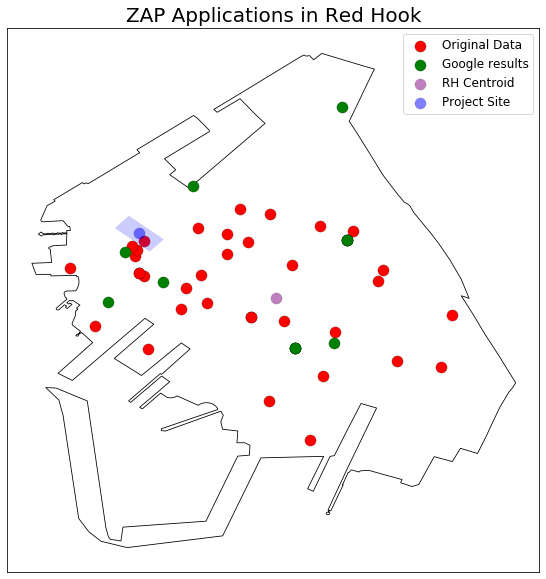

In [66]:
f, ax = plt.subplots(figsize=(10,10))
rh_tracts.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
rh_only.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=125,label='Original Data')
google_rh.plot(alpha=1, linewidth=0.2,ax=ax,color='g',edgecolor='black',markersize=125,label='Google results')
rh_centroid.plot(alpha=.5, linewidth=0.2,ax=ax,color='purple',edgecolor='black',markersize=125,label='RH Centroid')
site_poly.plot(alpha=.2, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=100)
site_centroid.plot(alpha=.5, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=125, \
                   label='Project Site')
plt.title("ZAP Applications in Red Hook", fontsize=20)
plt.legend(fontsize=12)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

## Normalize by population and plot again

In [37]:
# Set a multiplier for the normalized fields since they will otherwise be very small
norm_multiplier = 100

In [38]:
# Population data (will just take 2017 since we don't have historical data for ZAP)
pop_df = pd.read_csv('data/created_data/pop_time.csv')
pop_df.drop(pop_df.index[0:7], inplace=True)
pop_df.drop(['Year'], axis=1, inplace=True)
pop_df.reset_index(drop=True, inplace=True)
pop_df = pop_df.T
pop_df.reset_index(inplace=True)
pop_df.rename(columns={'index':'location',0:'pop'}, inplace=True)
pop_df

,location,pop
0,New York County,1653877
1,Kings County,2635121
2,Bronx County,1455846
3,Queens County,2339280
4,Richmond County,475948
5,New York City Total,8560072
6,Red Hook CTs,11316


In [39]:
# Drop and replace strings for next merge
pop_df['location'] = pop_df['location'].map(lambda x: x.rstrip(' County'))
pop_df['location'] = pop_df['location'].map(lambda x: x.replace('New York','Manhattan'))
pop_df['location'] = pop_df['location'].map(lambda x: x.replace('Kings','Brooklyn'))
pop_df['location'] = pop_df['location'].map(lambda x: x.replace('Richmond','Staten Island'))
pop_df

,location,pop
0,Manhattan,1653877
1,Brooklyn,2635121
2,Bronx,1455846
3,Queens,2339280
4,Staten Island,475948
5,Manhattan City Total,8560072
6,Red Hook CTs,11316


In [40]:
# Drop "Citywide" since population normalization will greatly skew the plot
zap_bor_gps.drop([2], inplace=True)

In [41]:
zap_pop = pd.merge(zap_bor_gps, pop_df, how='left', left_on='dcp_borough', right_on='location')
zap_pop.drop(['dcp_borough'], axis=1, inplace=True)
zap_pop['count_norm'] = zap_pop['count']/zap_pop['pop']*norm_multiplier
zap_pop

,count,location,pop,count_norm
0,2855,Bronx,1455846,0.196106
1,4175,Brooklyn,2635121,0.158437
2,10800,Manhattan,1653877,0.653011
3,3039,Queens,2339280,0.129912
4,7772,Staten Island,475948,1.632951


In [42]:
rh_count = rh_only.shape[0] + google_rh.shape[0]
rh_pop = pop_df.loc[6,'pop']
rh_dict = {'count': rh_count,
          'location':'Red Hook',
          'pop': rh_pop,
          'count_norm': rh_count/rh_pop*norm_multiplier}
rh_dict

{'count': 49,
 'location': 'Red Hook',
 'pop': 11316,
 'count_norm': 0.4330151997172146}

In [43]:
zap_pop = zap_pop.append(rh_dict, ignore_index=True)
zap_pop

,count,location,pop,count_norm
0,2855,Bronx,1455846,0.196106
1,4175,Brooklyn,2635121,0.158437
2,10800,Manhattan,1653877,0.653011
3,3039,Queens,2339280,0.129912
4,7772,Staten Island,475948,1.632951
5,49,Red Hook,11316,0.433015


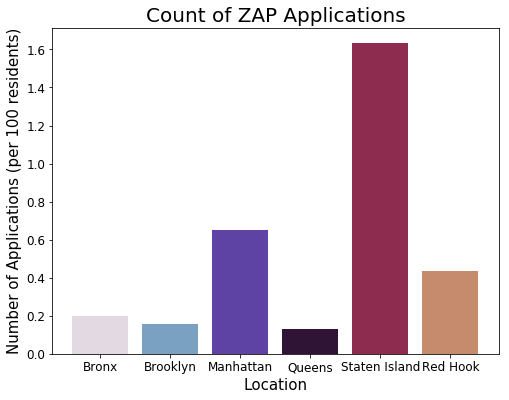

In [69]:
# Normalized counts
x = zap_pop['location']
y = zap_pop['count_norm']

plt.figure(figsize=(8,6))
for i in range(0,len(x)):
    plt.bar(x[i],y[i],color=cm.twilight(1.*i/len(x)))

plt.title("Count of ZAP Applications", fontsize=20)
plt.xlabel("Location", fontsize=15)
plt.ylabel("Number of Applications (per {} residents)".format(norm_multiplier), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Merge back with original data to fill in missing lat lon info

If I decide to look into the Google results more, here's how I could merge the data back in with the original dataframe that was missing latitude and longitude data.

In [45]:
# Create a column for the input string that was used to query the Google Geocode API
zap_null['input_string'] = zap_null['dcp_projectname'] + ', ' + zap_null['dcp_borough'] + ', NY, US'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
zap_null.reset_index(drop=True, inplace=True)

In [47]:
# Just keep the unique rows because that was causing merge issues
zap_null = zap_null.drop_duplicates(subset='input_string', keep='first')
zap_null.head()

,dcp_name,dcp_ceqrnumber,dcp_projectname,dcp_projectbrief,dcp_publicstatus_simp,dcp_borough,dcp_ulurp_nonulurp,dcp_communitydistricts,actiontypes,dcp_certifiedreferred,...,dcp_femafloodzonecoastala,dcp_femafloodzoneshadedx,dcp_femafloodzonev,applicants,lastmilestonedate,total_projects,has_centroid,center,ulurpnumbers,input_string
0,P2017R0360,19DCP150R,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA;ZA,2019-04-03T04:00:00.000Z,...,False,False,False,Peter Calvanico;Peter Calvanico,2019-06-10T04:00:00.000Z,29013,False,"[null,null]","[""N190308ZAR"",""N190310ZAR""]","45 Douglas Court, Staten Island, NY, US"
1,2019M0149,19DCP110Y,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,2019-01-28T19:22:12.000Z,...,False,False,False,DCP,2019-06-03T04:00:00.000Z,29013,False,"[null,null]","[""N190230ZRY""]",Residential Tower Mechanical Voids Text Amendm...
2,2019R0264,19DCP130R,SS 217 Main Street,This is a private application by Philese Black...,Completed,Staten Island,Non-ULURP,SI03,RC,2019-04-26T17:50:39.000Z,...,False,False,False,Philese Blackler,2019-04-25T04:00:00.000Z,29013,False,"[null,null]","[""N190269RCR""]","SS 217 Main Street, Staten Island, NY, US"
3,P2018M0038,03DCP031M,66 Hudson Boulevard Streetscape Text Amendment,A private application for a text amendment to ...,In Public Review,Manhattan,Non-ULURP,MN04,ZR,2018-12-17T05:00:00.000Z,...,False,False,False,Tishman Speyer,2019-04-24T21:53:10.000Z,29013,False,"[null,null]","[""N190205ZRM""]",66 Hudson Boulevard Streetscape Text Amendment...
4,2019K0287,NaN,Consolidation of ACS Division of Child Protection,This is a notice of intent by the New York Cit...,Completed,Brooklyn,Non-ULURP,BK02,PX;PX,2019-03-20T18:05:22.000Z,...,False,False,False,ACS;DCAS,2019-04-22T04:00:00.000Z,29013,False,"[null,null]","[""N190254PXK""]",Consolidation of ACS Division of Child Protect...


In [48]:
# Just keep the columns we need from the Google results
google_results = google_results[['input_string', 'latitude', 'longitude']]

In [49]:
# And drop duplicate rows
google_results.drop_duplicates(subset='input_string', keep='first', inplace=True)

In [50]:
# Merge in the Google results
zap_concat = zap_null.merge(google_results, how='inner', left_on='input_string', right_on='input_string')
zap_concat.head()

,dcp_name,dcp_ceqrnumber,dcp_projectname,dcp_projectbrief,dcp_publicstatus_simp,dcp_borough,dcp_ulurp_nonulurp,dcp_communitydistricts,actiontypes,dcp_certifiedreferred,...,dcp_femafloodzonev,applicants,lastmilestonedate,total_projects,has_centroid,center,ulurpnumbers,input_string,latitude,longitude
0,P2017R0360,19DCP150R,45 Douglas Court,This is a private application by Convery Inves...,In Public Review,Staten Island,ULURP,SI02,ZA;ZA,2019-04-03T04:00:00.000Z,...,False,Peter Calvanico;Peter Calvanico,2019-06-10T04:00:00.000Z,29013,False,"[null,null]","[""N190308ZAR"",""N190310ZAR""]","45 Douglas Court, Staten Island, NY, US",40.608527,-74.091696
1,2019M0149,19DCP110Y,Residential Tower Mechanical Voids Text Amendment,The Department of City Planning (DCP) proposes...,In Public Review,Manhattan,ULURP,CY00,ZR,2019-01-28T19:22:12.000Z,...,False,DCP,2019-06-03T04:00:00.000Z,29013,False,"[null,null]","[""N190230ZRY""]",Residential Tower Mechanical Voids Text Amendm...,40.783060,-73.971249
2,2019R0264,19DCP130R,SS 217 Main Street,This is a private application by Philese Black...,Completed,Staten Island,Non-ULURP,SI03,RC,2019-04-26T17:50:39.000Z,...,False,Philese Blackler,2019-04-25T04:00:00.000Z,29013,False,"[null,null]","[""N190269RCR""]","SS 217 Main Street, Staten Island, NY, US",40.509931,-74.247232
3,P2018M0038,03DCP031M,66 Hudson Boulevard Streetscape Text Amendment,A private application for a text amendment to ...,In Public Review,Manhattan,Non-ULURP,MN04,ZR,2018-12-17T05:00:00.000Z,...,False,Tishman Speyer,2019-04-24T21:53:10.000Z,29013,False,"[null,null]","[""N190205ZRM""]",66 Hudson Boulevard Streetscape Text Amendment...,40.755680,-74.000510
4,2019K0287,NaN,Consolidation of ACS Division of Child Protection,This is a notice of intent by the New York Cit...,Completed,Brooklyn,Non-ULURP,BK02,PX;PX,2019-03-20T18:05:22.000Z,...,False,ACS;DCAS,2019-04-22T04:00:00.000Z,29013,False,"[null,null]","[""N190254PXK""]",Consolidation of ACS Division of Child Protect...,40.678178,-73.944158


In [51]:
# Number of rows Google was able to match
zap_concat.shape

(5824, 23)

# Next steps

* We're trying to answer questions like: "How does Red Hook compare to the rest of Brooklyn? What about the rest of NYC?"
* Merge back with the original data if you have time